In [1]:
from torch.utils.data import random_split
import torchvision.datasets as ds
import os
import re
import shutil
import torchvision.transforms as tf

In [2]:
import sys
import pandas as pd

In [3]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split


In [4]:
def get_dataset(root_dir):
    dataset = ds.ImageFolder(
        root=root_dir,
        transform=tf.Compose([
            tf.Resize(224),
            tf.CenterCrop(224),
            tf.ToTensor(),
        ])
    )
    dlen = len(dataset)
    ratioList = [dlen - (dlen//5), dlen//5]
    tmp, test = random_split(dataset=dataset, lengths=ratioList)

    tlen = len(tmp)
    ratioList = [tlen - (tlen//5), tlen//5]
    train, val = random_split(dataset=tmp, lengths=ratioList)
    return train, val, test


In [5]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1:
            self.downsample = nn.Sequential(
                conv1x1(in_planes=in_channels, out_planes=out_channels, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        residual = x
        # print("1 ", o.shape)
        out = self.conv1(x)
        # print("2 ", out.shape)
        out = self.bn1(out)
        # print("3 ", out.shape)
        out = self.relu(out)
        # print("4 ", out.shape)
        out = self.conv2(out)
        # print("5 ", out.shape)
        out = self.bn2(out)
        # print("6 ", out.shape)
        if self.downsample is not None:
            residual = self.downsample(x)
            # print("DOWNSAMPLE ", out.shape)
        out += residual
        out = self.relu(out)
        return out

"""
image의 높이, 넓이가 둘 다 32의 배수여야 함. 그 외의 경우는 해봐야 알 것 같음
제일 바람직한 상황은 이미지가 224 x 224인 경우. (ImageNet)
정사각형 아니고, 둘다 32의 배수기만 해도 돌아감
"""
class ResNet18(nn.Module):
    def __init__(self, in_channels, heigth=224, width=224, labelNum=1000):
        super(ResNet18, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxp = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.block1 = nn.Sequential(
            ResidualBlock(in_channels=64, out_channels=64),
            ResidualBlock(in_channels=64, out_channels=64)
        )
        self.block2 = nn.Sequential(
            ResidualBlock(in_channels=64, out_channels=128, stride=2),
            ResidualBlock(in_channels=128, out_channels=128)
        )
        self.block3 = nn.Sequential(
            ResidualBlock(in_channels=128, out_channels=256, stride=2),
            ResidualBlock(in_channels=256, out_channels=256)
        )
        self.block4 = nn.Sequential(
            ResidualBlock(in_channels=256, out_channels=512, stride=2),
            ResidualBlock(in_channels=512, out_channels=512)
        )
        self.avgp = nn.AvgPool2d(kernel_size=(width//32, heigth//32))
        self.fc = nn.Linear(in_features=512, out_features=labelNum)

    
    def forward(self, x):
        # print('0 ', x.shape)
        o = self.conv(x)
        # print('1 ', o.shape)
        o = self.maxp(o)
        # print('2 ', o.shape)
        o = self.block1(o)
        # print('3 ', o.shape)
        o = self.block2(o)
        # print('4 ', o.shape)
        o = self.block3(o)
        # print('5 ', o.shape)
        o = self.block4(o)
        # print('6 ', o.shape)
        o = self.avgp(o)
        # print('7 ', o.shape)
        o = o.view(o.size(0), -1)
        # print('8 ', o.shape)
        o = self.fc(o)
        return o

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
IMAGE_ROOT = '/content/drive/MyDrive/kcars'
BATCH_SIZE = 16
LR = 0.001
EPOCH = 30


gpu_flag = torch.cuda.is_available()
device = torch.device("cuda" if gpu_flag else "cpu")
# device = torch.device("cpu")
print(device)

# 한번만 실행하면 됨
#reorg_root(IMAGE_ROOT)

trainSet, valSet, testSet = get_dataset(IMAGE_ROOT)





cuda


In [8]:
#instead of using test, just use validate group
def train():
  gpu_flag = torch.cuda.is_available()
  device = torch.device("cuda" if gpu_flag else "cpu")
  print(device)


  model = ResNet18(in_channels=3, labelNum=100)
  optim = torch.optim.Adam(model.parameters(), lr=LR)
  loss_func = nn.CrossEntropyLoss()

  train_loss_arr = []
  val_loss_arr = []
  val_acc_arr = []

  model.to(device)
  for epoch in range(1, EPOCH+1):
      train_loss = 0
      val_loss = 0
      val_acc = 0
      for i, (x,y) in enumerate(tqdm(train_dataloader)):
          model.train()
          x, y = x.to(device), y.to(device)
          optim.zero_grad()
          pred = model(x)

          loss = loss_func(pred, y)
          train_loss += loss.item()

          loss.backward()
          optim.step()
          # break
      
      for i, (x,y) in enumerate(val_dataloader):
          model.eval()
          x, y = x.to(device), y.to(device)
          pred = model(x)

          loss = loss_func(pred, y)
          val_loss += loss.item()

          check = torch.argmax(pred, dim=1) == y
          val_acc += check.float().mean()
          # break

      train_loss = train_loss / len(train_dataloader)
      val_loss = val_loss / len(val_dataloader)
      val_acc = val_acc/len(val_dataloader)
      train_loss_arr.append(train_loss)
      val_loss_arr.append(val_loss)
      val_acc_arr.append(val_acc)

      print(f'epoch: {epoch}, train_loss: {train_loss}, val_loss: {val_loss}, acc: {val_acc}')
      
    
  state = { 'model': model.state_dict(), 'optimizer':optim.state_dict(), 'epoch': epoch }   
  torch.save(state, '/content/drive/MyDrive/result')
      


In [9]:
BATCH_SIZE = 16
LR = 0.001
EPOCH = 30

train_dataloader = DataLoader(trainSet, batch_size=BATCH_SIZE, num_workers=1)
val_dataloader = DataLoader(valSet, batch_size=BATCH_SIZE, num_workers=1)
test_dataloader = DataLoader(testSet, batch_size=BATCH_SIZE, num_workers=1)
train()

cuda


100%|██████████| 758/758 [09:14<00:00,  1.37it/s]


epoch: 1, train_loss: 3.7474344213908455, val_loss: 7.7272562478718, acc: 0.042434211820364


100%|██████████| 758/758 [03:38<00:00,  3.47it/s]


epoch: 2, train_loss: 2.811286286345258, val_loss: 6.476623387085764, acc: 0.10000000149011612


100%|██████████| 758/758 [03:37<00:00,  3.49it/s]


epoch: 3, train_loss: 2.146461570168548, val_loss: 6.775270167149995, acc: 0.1292763203382492


100%|██████████| 758/758 [03:39<00:00,  3.45it/s]


epoch: 4, train_loss: 1.566902195676021, val_loss: 3.566487105269181, acc: 0.27598685026168823


100%|██████████| 758/758 [03:37<00:00,  3.48it/s]


epoch: 5, train_loss: 1.0621847817797145, val_loss: 3.1298907712886206, acc: 0.35131579637527466


100%|██████████| 758/758 [03:38<00:00,  3.46it/s]


epoch: 6, train_loss: 0.6957679417839465, val_loss: 1.4072170144633243, acc: 0.6085526347160339


100%|██████████| 758/758 [03:36<00:00,  3.50it/s]


epoch: 7, train_loss: 0.4491092819956409, val_loss: 1.0208540760372815, acc: 0.7006579041481018


100%|██████████| 758/758 [03:37<00:00,  3.48it/s]


epoch: 8, train_loss: 0.29693072100015144, val_loss: 0.7391326977626274, acc: 0.7694079279899597


100%|██████████| 758/758 [03:38<00:00,  3.48it/s]


epoch: 9, train_loss: 0.20422921164727972, val_loss: 0.9944176375081665, acc: 0.741447389125824


100%|██████████| 758/758 [03:37<00:00,  3.48it/s]


epoch: 10, train_loss: 0.15742274110099808, val_loss: 1.759715841004723, acc: 0.6687500476837158


100%|██████████| 758/758 [03:38<00:00,  3.47it/s]


epoch: 11, train_loss: 0.14493847996890938, val_loss: 0.6169753546483423, acc: 0.8253290057182312


100%|██████████| 758/758 [03:37<00:00,  3.48it/s]


epoch: 12, train_loss: 0.1324523573926844, val_loss: 0.7346967693366949, acc: 0.803947389125824


100%|██████████| 758/758 [03:37<00:00,  3.48it/s]


epoch: 13, train_loss: 0.10359370828597587, val_loss: 0.6442118168048757, acc: 0.8253290057182312


100%|██████████| 758/758 [03:36<00:00,  3.50it/s]


epoch: 14, train_loss: 0.10670636299141194, val_loss: 1.7772642456387218, acc: 0.6819079518318176


100%|██████████| 758/758 [03:38<00:00,  3.47it/s]


epoch: 15, train_loss: 0.0910770940470895, val_loss: 0.5298761194179716, acc: 0.870394766330719


100%|██████████| 758/758 [03:38<00:00,  3.48it/s]


epoch: 16, train_loss: 0.0871779188301198, val_loss: 0.5645954084950254, acc: 0.8460526466369629


100%|██████████| 758/758 [03:38<00:00,  3.46it/s]


epoch: 17, train_loss: 0.07170307046344004, val_loss: 0.4250538851091589, acc: 0.8871710896492004


100%|██████████| 758/758 [03:36<00:00,  3.50it/s]


epoch: 18, train_loss: 0.0813887291831317, val_loss: 0.47830352874987414, acc: 0.8756579160690308


100%|██████████| 758/758 [03:39<00:00,  3.46it/s]


epoch: 19, train_loss: 0.06874770213289114, val_loss: 0.4610684722318853, acc: 0.8901315927505493


100%|██████████| 758/758 [03:37<00:00,  3.49it/s]


epoch: 20, train_loss: 0.031075921429192622, val_loss: 0.6591117917805126, acc: 0.843092143535614


100%|██████████| 758/758 [03:41<00:00,  3.42it/s]


epoch: 21, train_loss: 0.09591380439089435, val_loss: 0.3636274029525291, acc: 0.9046053290367126


100%|██████████| 758/758 [03:37<00:00,  3.49it/s]


epoch: 22, train_loss: 0.04361119515581688, val_loss: 0.8442721841409557, acc: 0.8217105865478516


100%|██████████| 758/758 [03:38<00:00,  3.48it/s]


epoch: 23, train_loss: 0.06280087291906246, val_loss: 0.7293898503345094, acc: 0.847039520740509


100%|██████████| 758/758 [03:37<00:00,  3.48it/s]


epoch: 24, train_loss: 0.051250594346757945, val_loss: 1.2370241446518584, acc: 0.737500011920929


100%|██████████| 758/758 [03:38<00:00,  3.48it/s]


epoch: 25, train_loss: 0.041536867526027504, val_loss: 0.4590930422265573, acc: 0.8838816285133362


100%|██████████| 758/758 [03:39<00:00,  3.45it/s]


epoch: 26, train_loss: 0.05147057172883906, val_loss: 1.7524162130136238, acc: 0.691447377204895


100%|██████████| 758/758 [03:37<00:00,  3.48it/s]


epoch: 27, train_loss: 0.05401429374773345, val_loss: 0.7503307225464501, acc: 0.8411184549331665


100%|██████████| 758/758 [03:38<00:00,  3.47it/s]


epoch: 28, train_loss: 0.02337892270930502, val_loss: 0.3515478776265426, acc: 0.9115132093429565


100%|██████████| 758/758 [03:37<00:00,  3.49it/s]


epoch: 29, train_loss: 0.02235250096079094, val_loss: 1.8973716300176946, acc: 0.674342155456543


100%|██████████| 758/758 [03:38<00:00,  3.48it/s]


epoch: 30, train_loss: 0.09092753320155043, val_loss: 0.42693284761810085, acc: 0.8947368860244751


In [11]:
BATCH_SIZE = 16
LR = 0.003
EPOCH = 50

train_dataloader = DataLoader(trainSet, batch_size=BATCH_SIZE, num_workers=1)
val_dataloader = DataLoader(valSet, batch_size=BATCH_SIZE, num_workers=1)
test_dataloader = DataLoader(testSet, batch_size=BATCH_SIZE, num_workers=1)

train()

cuda


100%|██████████| 758/758 [03:37<00:00,  3.49it/s]


epoch: 1, train_loss: 3.9363054697620523, val_loss: 3.5476132919913845, acc: 0.09638158231973648


100%|██████████| 758/758 [03:38<00:00,  3.47it/s]


epoch: 2, train_loss: 2.9920236966855294, val_loss: 2.5965427492794237, acc: 0.28453949093818665


100%|██████████| 758/758 [03:39<00:00,  3.45it/s]


epoch: 3, train_loss: 2.3019676420808155, val_loss: 2.1208294680244046, acc: 0.3865131735801697


100%|██████████| 758/758 [03:38<00:00,  3.47it/s]


epoch: 4, train_loss: 1.6589286750216912, val_loss: 1.8168303703006945, acc: 0.47828948497772217


100%|██████████| 758/758 [03:39<00:00,  3.45it/s]


epoch: 5, train_loss: 1.0850852116018455, val_loss: 1.3182321290436545, acc: 0.5960526466369629


100%|██████████| 758/758 [03:37<00:00,  3.48it/s]


epoch: 6, train_loss: 0.6702402823538296, val_loss: 1.7749415957613994, acc: 0.5572368502616882


100%|██████████| 758/758 [03:39<00:00,  3.45it/s]


epoch: 7, train_loss: 0.40219719904059625, val_loss: 1.1220572363781303, acc: 0.6950657963752747


100%|██████████| 758/758 [03:37<00:00,  3.49it/s]


epoch: 8, train_loss: 0.2671903976304383, val_loss: 1.108397971721072, acc: 0.7059210538864136


100%|██████████| 758/758 [03:38<00:00,  3.47it/s]


epoch: 9, train_loss: 0.1999592140543036, val_loss: 2.044554152143629, acc: 0.5796052813529968


100%|██████████| 758/758 [03:36<00:00,  3.50it/s]


epoch: 10, train_loss: 0.16501906295036675, val_loss: 1.3019141621887684, acc: 0.7115131616592407


100%|██████████| 758/758 [03:39<00:00,  3.46it/s]


epoch: 11, train_loss: 0.13647106192615324, val_loss: 0.8113429664094981, acc: 0.7976974248886108


100%|██████████| 758/758 [03:38<00:00,  3.47it/s]


epoch: 12, train_loss: 0.11399742044474055, val_loss: 0.6094919361909361, acc: 0.8342105746269226


100%|██████████| 758/758 [03:38<00:00,  3.47it/s]


epoch: 13, train_loss: 0.11802585071995904, val_loss: 0.8741861513374667, acc: 0.7792763710021973


100%|██████████| 758/758 [03:38<00:00,  3.46it/s]


epoch: 14, train_loss: 0.08314421573468904, val_loss: 1.415073706366514, acc: 0.706250011920929


100%|██████████| 758/758 [03:36<00:00,  3.51it/s]


epoch: 15, train_loss: 0.09781790941742945, val_loss: 0.6016577207377275, acc: 0.8493421673774719


100%|██████████| 758/758 [03:39<00:00,  3.46it/s]


epoch: 16, train_loss: 0.0953025290336138, val_loss: 0.7753348031326344, acc: 0.8072368502616882


100%|██████████| 758/758 [03:38<00:00,  3.47it/s]


epoch: 17, train_loss: 0.06099927821868538, val_loss: 2.209864476793691, acc: 0.6401315927505493


100%|██████████| 758/758 [03:39<00:00,  3.46it/s]


epoch: 18, train_loss: 0.08321477373245499, val_loss: 1.2431588785820886, acc: 0.7335526347160339


100%|██████████| 758/758 [03:37<00:00,  3.48it/s]


epoch: 19, train_loss: 0.06712501215209261, val_loss: 0.7772287342280738, acc: 0.8174342513084412


100%|██████████| 758/758 [03:39<00:00,  3.46it/s]


epoch: 20, train_loss: 0.053192394041093216, val_loss: 0.6272715247407752, acc: 0.8638158440589905


100%|██████████| 758/758 [03:36<00:00,  3.49it/s]


epoch: 21, train_loss: 0.05493948807710128, val_loss: 0.7250988930034893, acc: 0.8299342393875122


100%|██████████| 758/758 [03:40<00:00,  3.43it/s]


epoch: 22, train_loss: 0.07303311224831183, val_loss: 0.9931502819404399, acc: 0.7861842513084412


100%|██████████| 758/758 [03:41<00:00,  3.42it/s]


epoch: 23, train_loss: 0.03280835978372043, val_loss: 0.6011746196566443, acc: 0.8601974248886108


100%|██████████| 758/758 [03:39<00:00,  3.45it/s]


epoch: 24, train_loss: 0.0677651488566398, val_loss: 0.8321803767307613, acc: 0.8138158321380615


100%|██████████| 758/758 [03:39<00:00,  3.46it/s]


epoch: 25, train_loss: 0.048252522370200245, val_loss: 0.5800094526677736, acc: 0.8730263710021973


100%|██████████| 758/758 [03:38<00:00,  3.47it/s]


epoch: 26, train_loss: 0.03929959745768534, val_loss: 0.5864843759293619, acc: 0.8667763471603394


100%|██████████| 758/758 [03:41<00:00,  3.43it/s]


epoch: 27, train_loss: 0.051597449780488046, val_loss: 0.5474176198913483, acc: 0.8700658082962036


100%|██████████| 758/758 [03:37<00:00,  3.49it/s]


epoch: 28, train_loss: 0.05533317118666352, val_loss: 0.6469291341650348, acc: 0.85164475440979


100%|██████████| 758/758 [03:40<00:00,  3.44it/s]


epoch: 29, train_loss: 0.019498314364557515, val_loss: 1.059863428021536, acc: 0.7973684668540955


100%|██████████| 758/758 [03:37<00:00,  3.48it/s]


epoch: 30, train_loss: 0.05143845569118111, val_loss: 0.8103728731554982, acc: 0.8289474248886108


100%|██████████| 758/758 [03:39<00:00,  3.45it/s]


epoch: 31, train_loss: 0.03442605298786329, val_loss: 0.5759950032797765, acc: 0.8680921196937561


100%|██████████| 758/758 [03:39<00:00,  3.46it/s]


epoch: 32, train_loss: 0.04559555302269936, val_loss: 2.0769321452152276, acc: 0.6710526347160339


100%|██████████| 758/758 [03:39<00:00,  3.46it/s]


epoch: 33, train_loss: 0.04643210403944756, val_loss: 0.5962536653356725, acc: 0.8648026585578918


100%|██████████| 758/758 [03:39<00:00,  3.45it/s]


epoch: 34, train_loss: 0.019479359034362473, val_loss: 0.3604041752096045, acc: 0.9164474010467529


100%|██████████| 758/758 [03:38<00:00,  3.47it/s]


epoch: 35, train_loss: 0.03752083502560449, val_loss: 0.6306979317113904, acc: 0.870394766330719


100%|██████████| 758/758 [03:41<00:00,  3.43it/s]


epoch: 36, train_loss: 0.0384247285623766, val_loss: 0.4524532385951668, acc: 0.8944079279899597


100%|██████████| 758/758 [03:39<00:00,  3.46it/s]


epoch: 37, train_loss: 0.030063933670329532, val_loss: 0.4300905879252241, acc: 0.8996710777282715


100%|██████████| 758/758 [03:39<00:00,  3.45it/s]


epoch: 38, train_loss: 0.022402087306706363, val_loss: 0.5702873434975596, acc: 0.8855263590812683


100%|██████████| 758/758 [03:38<00:00,  3.47it/s]


epoch: 39, train_loss: 0.02356874484776967, val_loss: 0.4903504161357935, acc: 0.893750011920929


100%|██████████| 758/758 [03:40<00:00,  3.44it/s]


epoch: 40, train_loss: 0.04874782182975163, val_loss: 0.49278018640930227, acc: 0.8917763829231262


100%|██████████| 758/758 [03:39<00:00,  3.45it/s]


epoch: 41, train_loss: 0.028900927418297005, val_loss: 0.7612287053918024, acc: 0.8585526943206787


100%|██████████| 758/758 [03:39<00:00,  3.45it/s]


epoch: 42, train_loss: 0.013047926866540297, val_loss: 0.37323008239725725, acc: 0.9144737124443054


100%|██████████| 758/758 [03:39<00:00,  3.45it/s]


epoch: 43, train_loss: 0.03424664423942588, val_loss: 0.6146799060270974, acc: 0.8654605746269226


100%|██████████| 758/758 [03:39<00:00,  3.45it/s]


epoch: 44, train_loss: 0.03018014845787845, val_loss: 2.0006956299668865, acc: 0.7023026347160339


100%|██████████| 758/758 [03:39<00:00,  3.45it/s]


epoch: 45, train_loss: 0.019358168322630064, val_loss: 1.001910079645581, acc: 0.8144737482070923


100%|██████████| 758/758 [03:38<00:00,  3.48it/s]


epoch: 46, train_loss: 0.025665163693219854, val_loss: 1.0091375540366003, acc: 0.819736897945404


100%|██████████| 758/758 [03:40<00:00,  3.44it/s]


epoch: 47, train_loss: 0.02923662416130996, val_loss: 0.3939516291396055, acc: 0.9177631735801697


100%|██████████| 758/758 [03:38<00:00,  3.47it/s]


epoch: 48, train_loss: 0.015614706866807023, val_loss: 0.7188025657727849, acc: 0.8552631735801697


100%|██████████| 758/758 [03:40<00:00,  3.45it/s]


epoch: 49, train_loss: 0.029514248280356023, val_loss: 0.43119963834148, acc: 0.9078947901725769


100%|██████████| 758/758 [03:38<00:00,  3.47it/s]


epoch: 50, train_loss: 0.019745831921554324, val_loss: 0.5403541632393363, acc: 0.8953948020935059


In [13]:
model = ResNet18(in_channels=3, labelNum=100)
optim = torch.optim.Adam(model.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

checkpoint = torch.load('/content/drive/MyDrive/result')
model.load_state_dict(checkpoint['model'])
optim.load_state_dict(checkpoint['optimizer'])
start_epoch = checkpoint['epoch']+1


In [19]:
test_loss = 0
test_acc = 0
gpu_flag = torch.cuda.is_available()
device = torch.device("cuda" if gpu_flag else "cpu")

print(device)
for i, (x,y) in enumerate(test_dataloader):
    if torch.cuda.is_available():
      model.cuda()
      x, y = x.to(device), y.to(device)
    model.eval()
    pred = model(x)

    loss = loss_func(pred, y)
    test_loss += loss.item()

    check = torch.argmax(pred, dim=1) == y
    test_acc += check.float().mean()
    # break

test_loss = test_loss / len(test_dataloader)
test_acc = test_acc /len(test_dataloader)
print(f'Accuracy: {test_acc * 100 :.2f}%')

cuda
Accuracy: 89.08%


In [20]:
filter_map = []
for param in list(model.parameters()):
  if param.dim() == 4:
    print(param.shape)
    filter_map.append(param)

torch.Size([64, 3, 7, 7])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 64, 1, 1])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([256, 128, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 128, 1, 1])
torch.Size([256, 256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([512, 256, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 256, 1, 1])
torch.Size([512, 512, 3, 3])
torch.Size([512, 512, 3, 3])


In [28]:
#Make the function for feature map visualization
#tensor = (input filter), ch = (channel of filter you want to see)
import matplotlib.pyplot as plt
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torchvision import utils

def visTensor(tensor, ch=3, allkernels=False, nrow=8, padding=1): 
  tensor = tensor.cpu()
  n,c,w,h = tensor.shape

  if allkernels: 
    tensor = tensor.view(n*c, -1, w, h)
  elif c != 3: 
    tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
    
  rows = np.min((tensor.shape[0] // nrow + 1, 64))    
  grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
  plt.figure( figsize=(nrow,rows) )
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

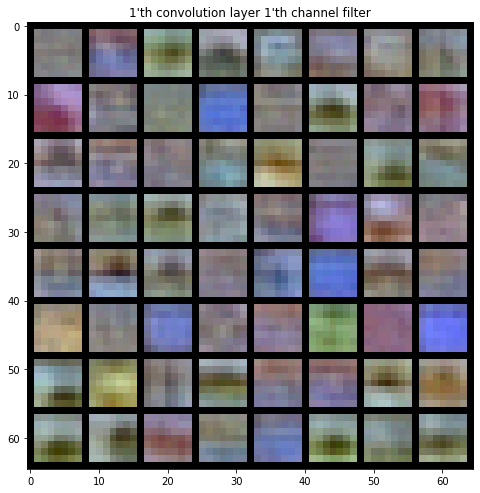

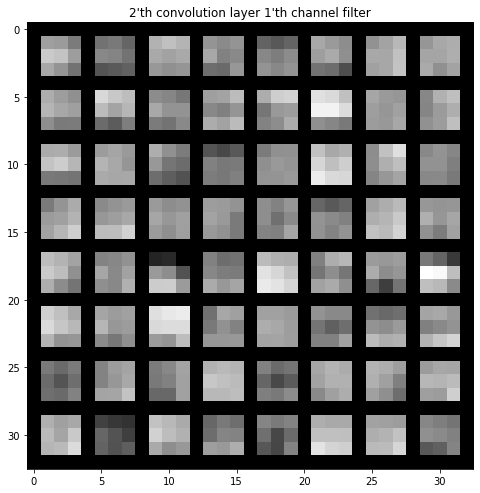

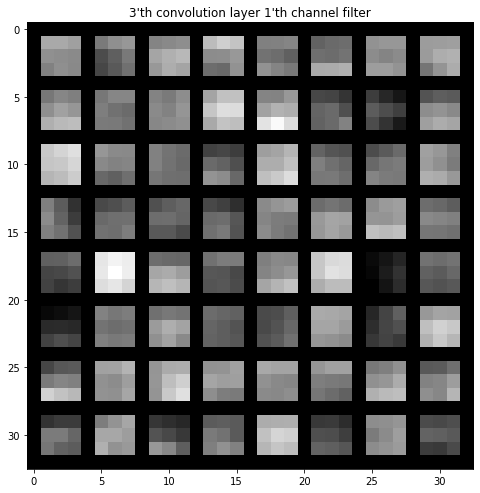

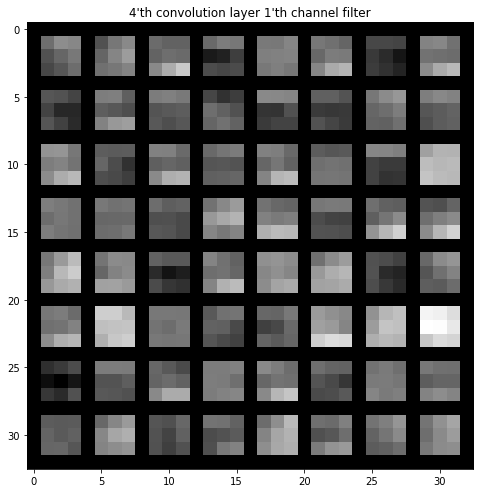

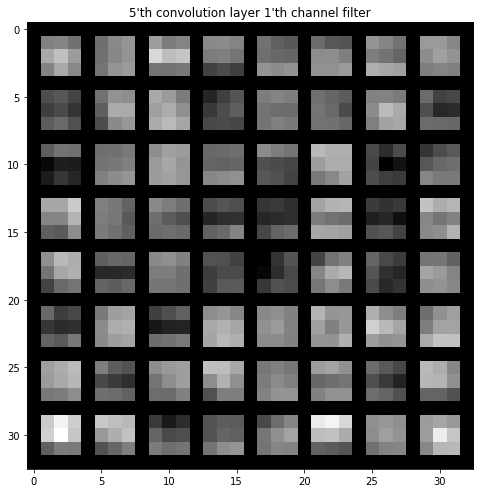

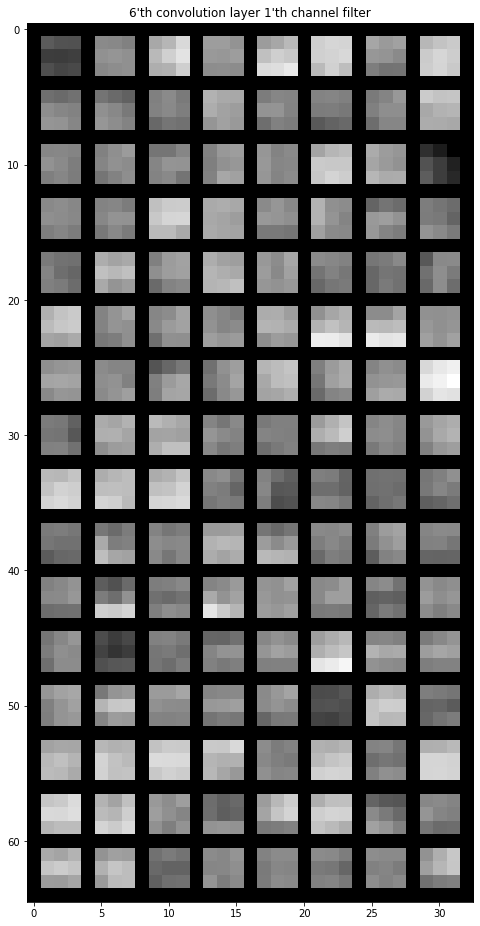

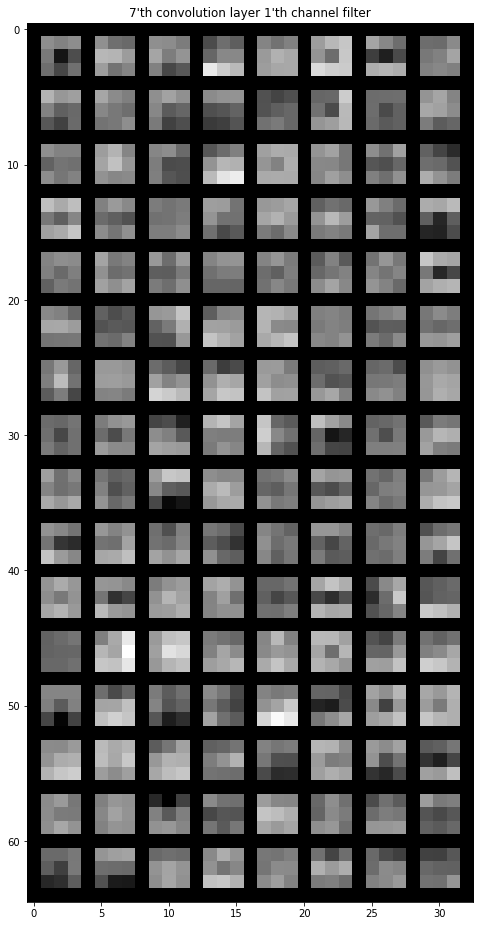

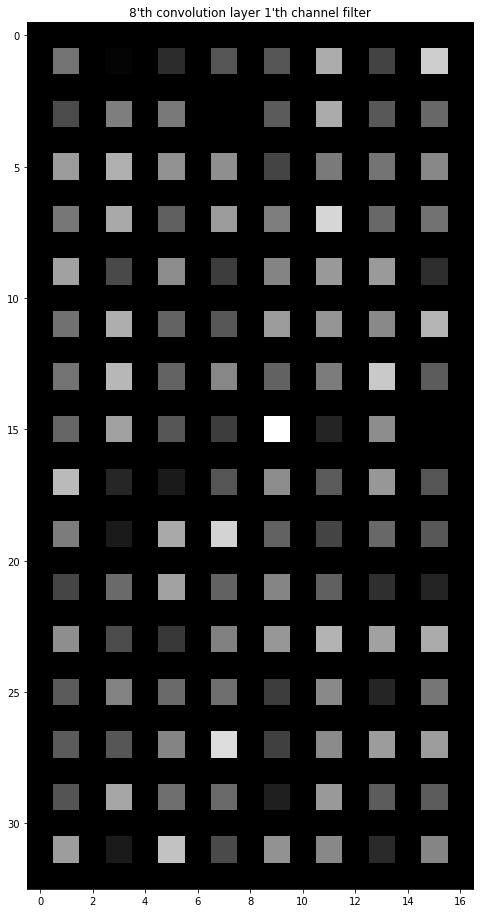

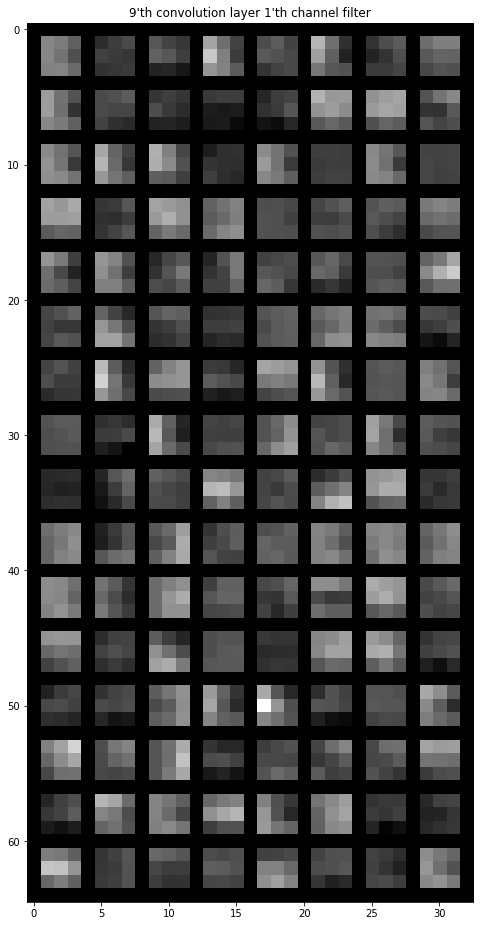

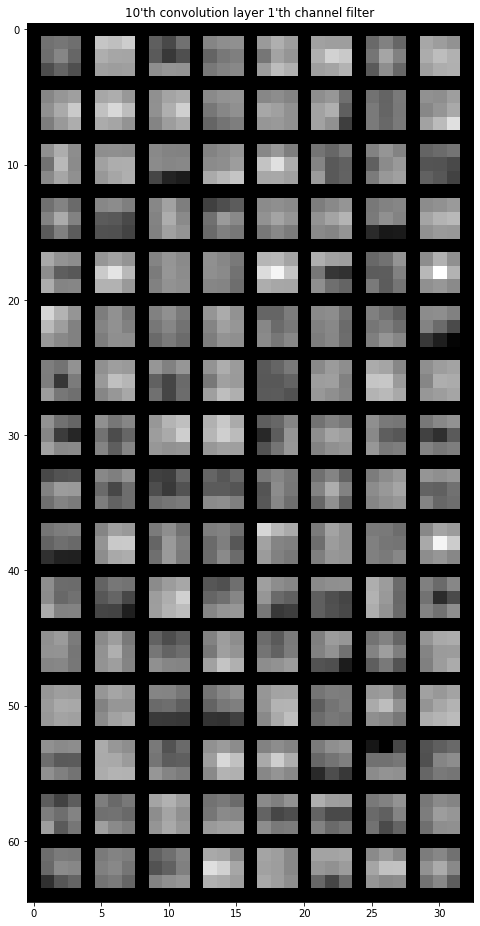

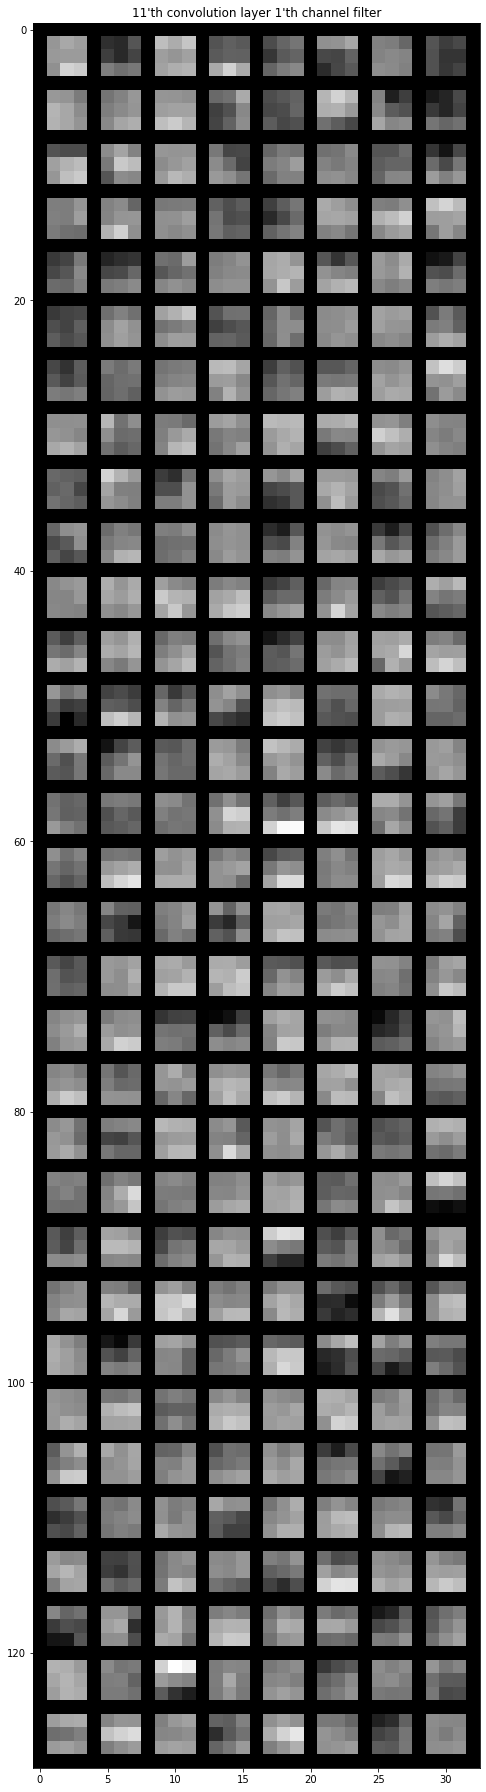

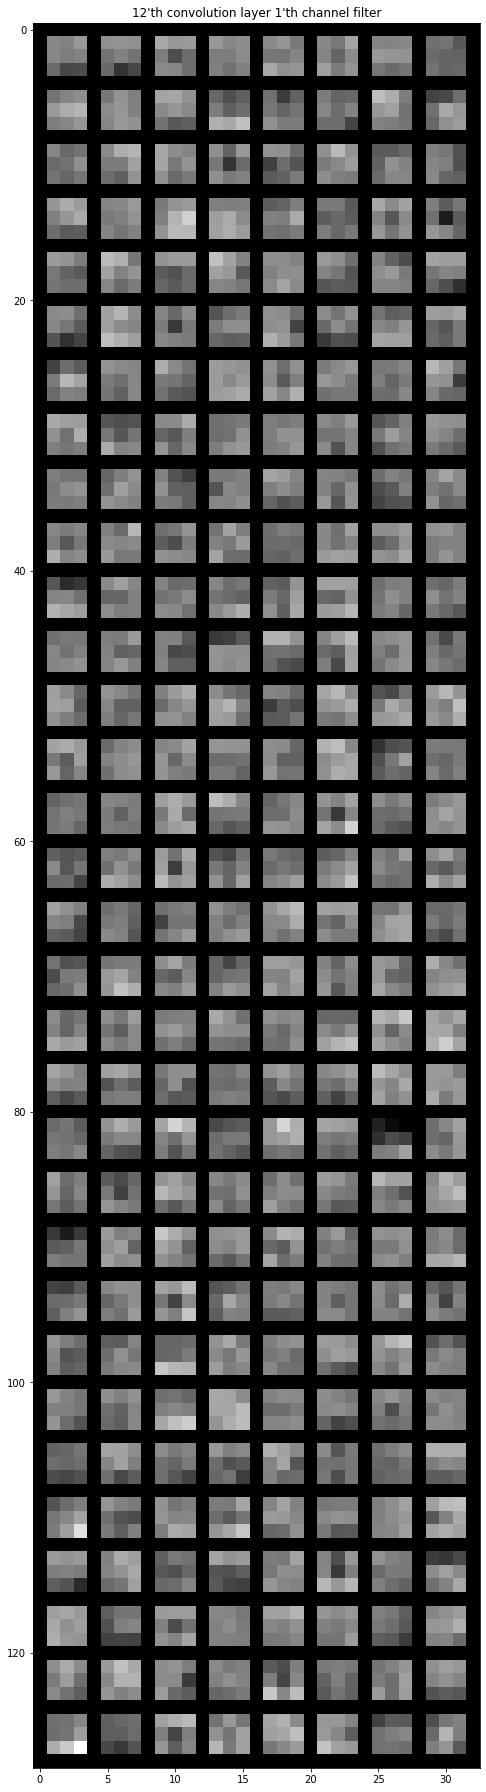

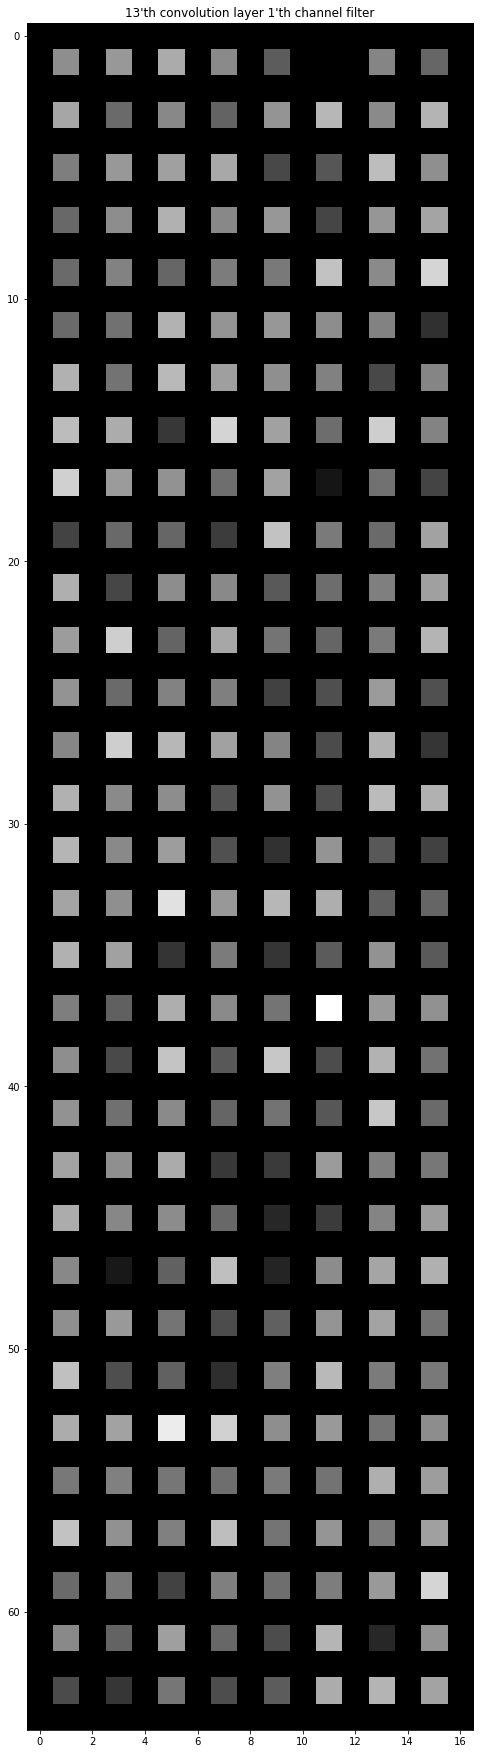

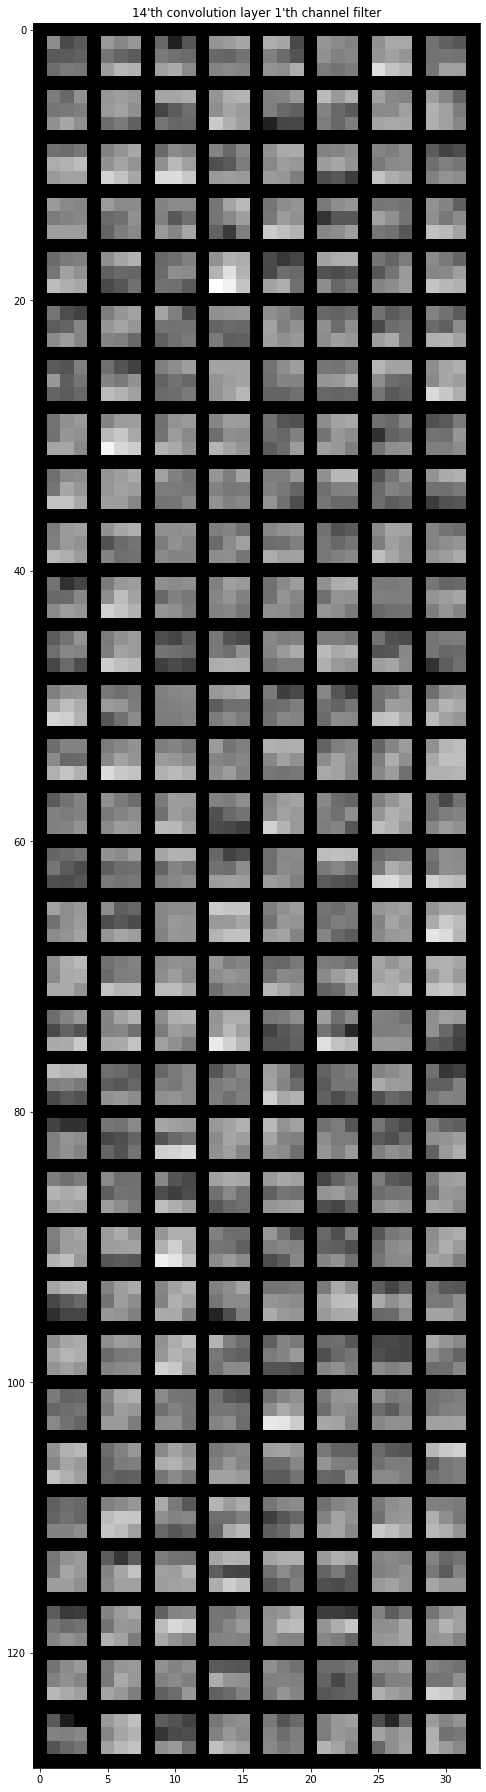

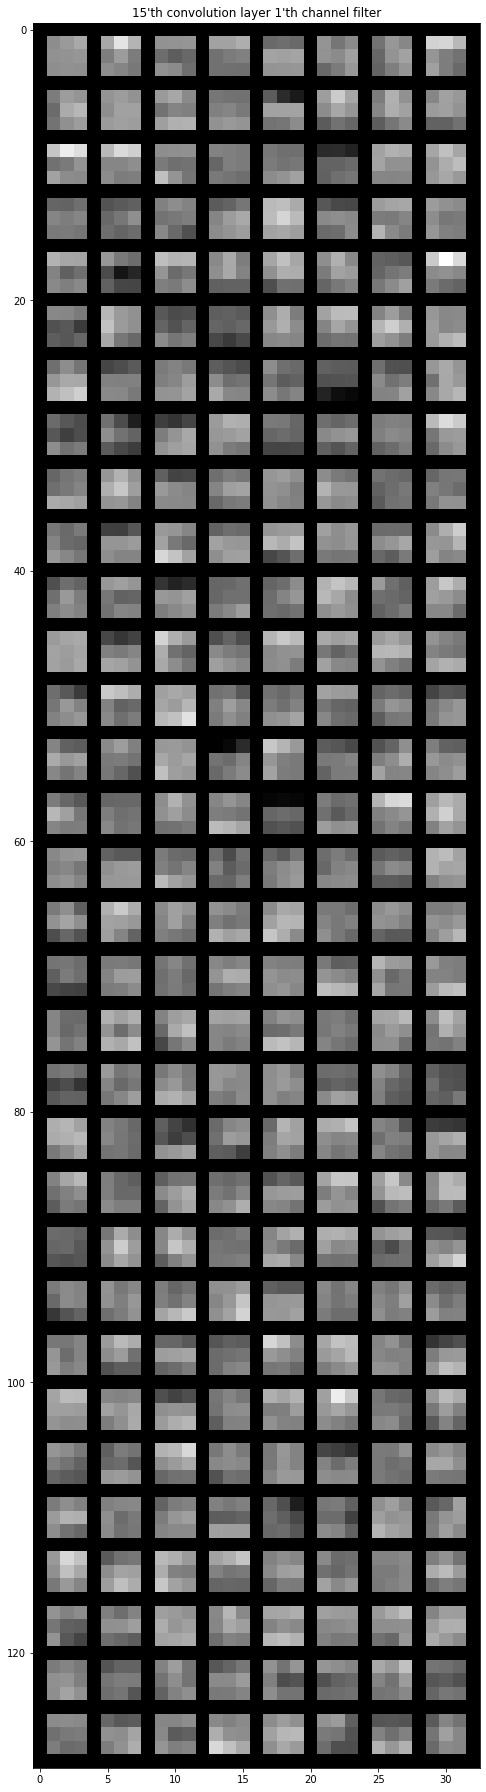

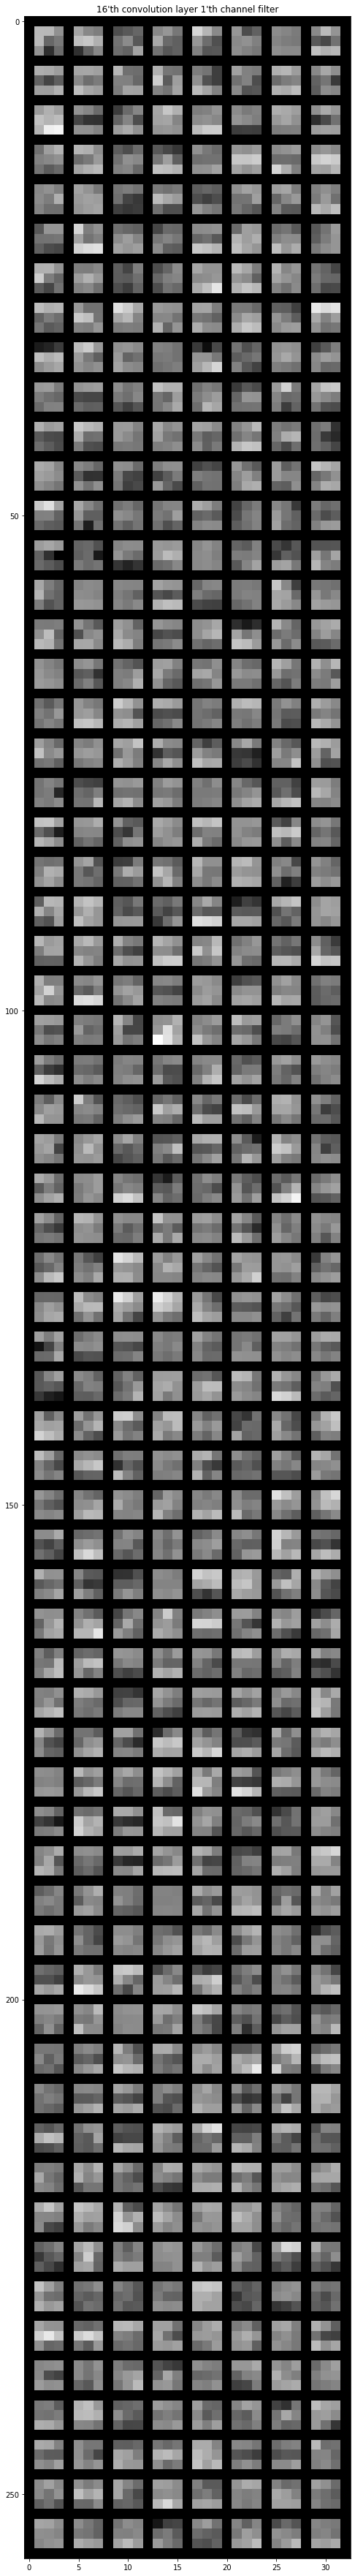

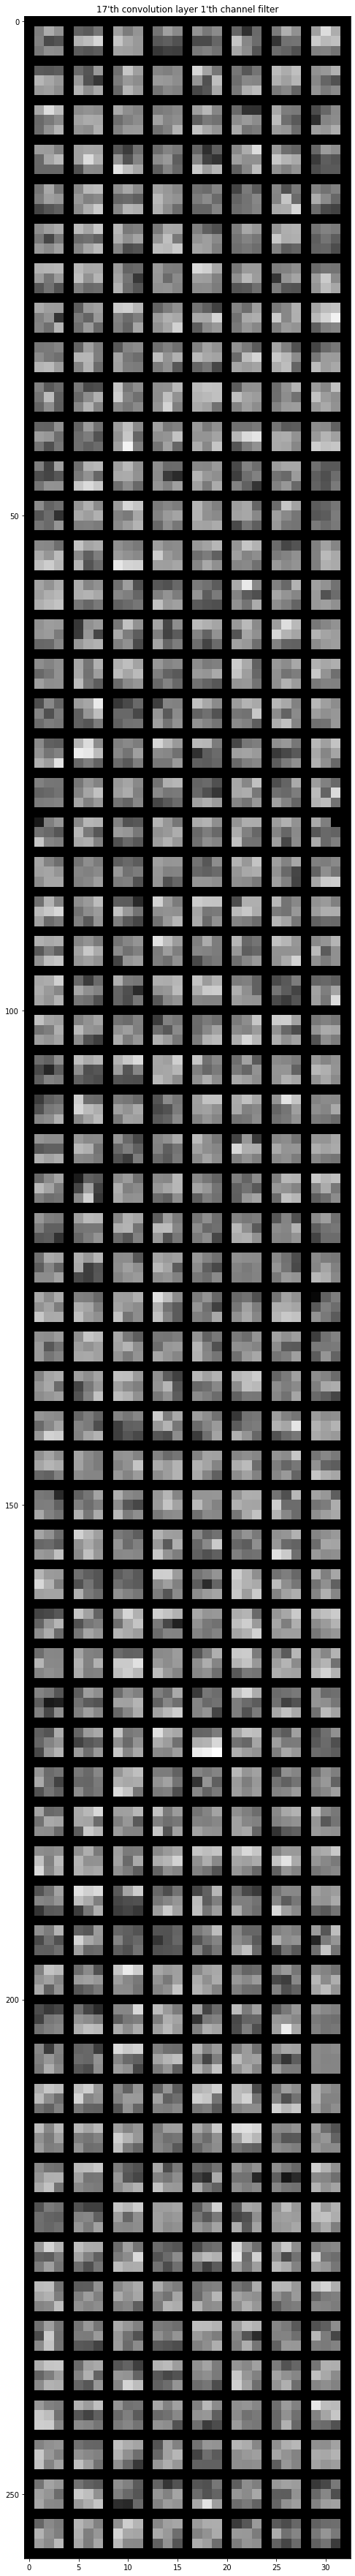

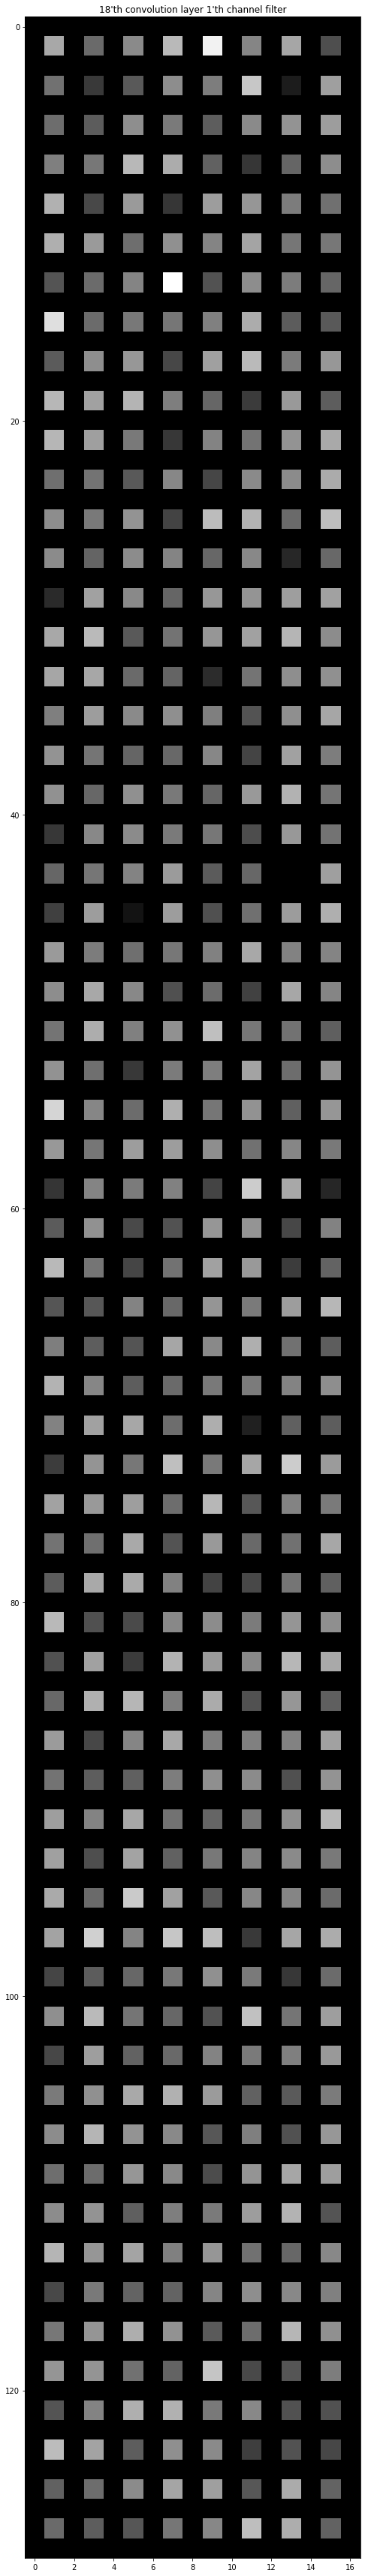

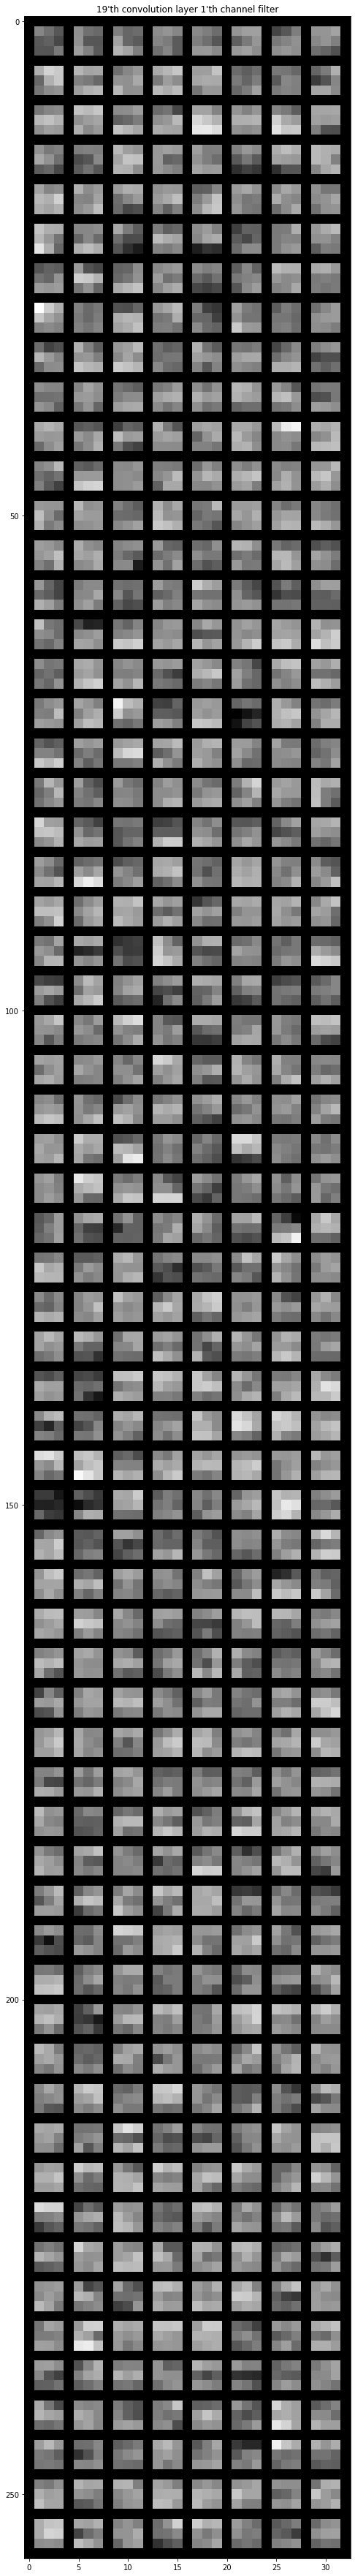

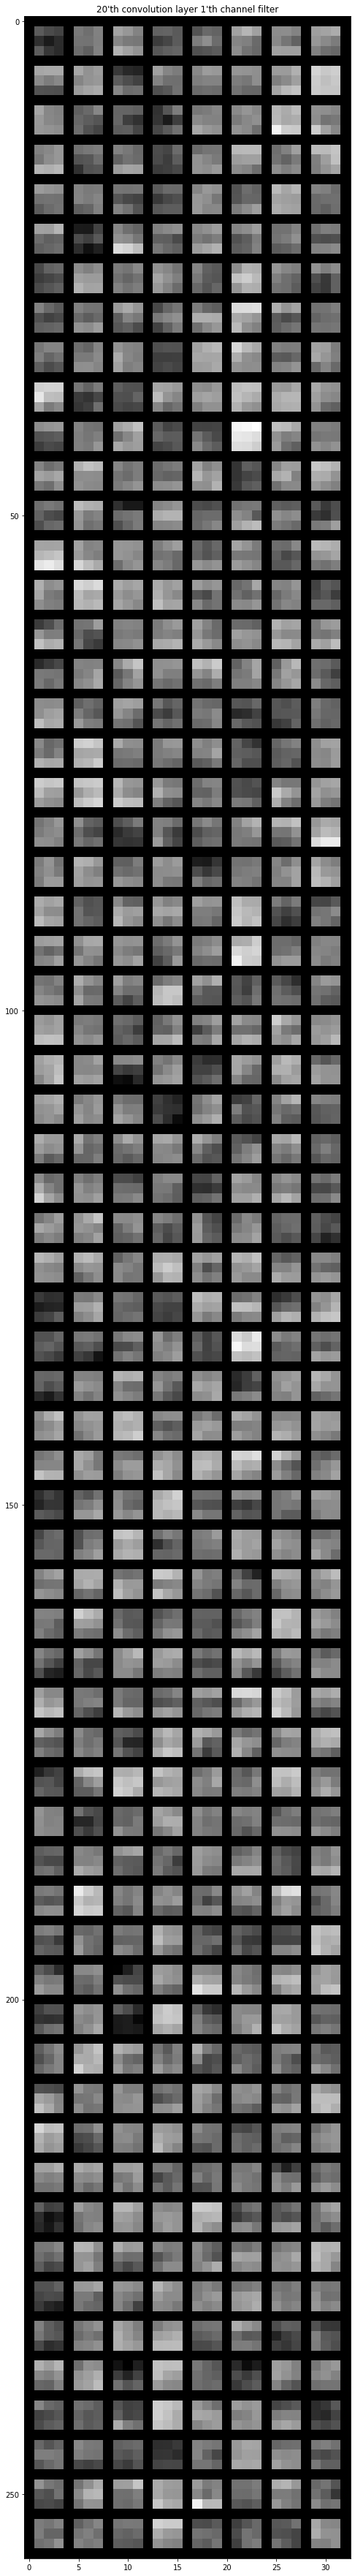

In [30]:
for n, weight in enumerate(filter_map):
  ch = 0
  visTensor(weight, ch=0, allkernels=False)
  plt.title(f'{n+1}\'th convolution layer {ch+1}\'th channel filter')

In [ ]:
# 4. Return the best set of hyper-parameters for the model.
print(f'Accuracy: {gs.best_score_ * 100 :.2f}%')
print(gs.best_params_)